In [259]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data import ee_utils
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
from src.processing.control import random_control
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from src.processing.control import random_control, eval, nearest, terrain_clustering
from src.data import k_nn
from src.data import clustering

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)
importlib.reload(random_control)
importlib.reload(eval)
importlib.reload(terrain_clustering)
importlib.reload(k_nn)
importlib.reload(clustering)

2023-06-11 22:51:35,640 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-11 22:51:35,642 DEBUG: Logger /home/jk871/fire-regen/src/data/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-11 22:51:35,643 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-11 22:51:35,644 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.clustering' from '/home/jk871/fire-regen/src/data/clustering.py'>

In [26]:
sierras = gpd.read_file(f"{USER_PATH}/data/shapefiles/sierras_convex_hull.shp")
sierras_3310 = sierras.to_crs(epsg=3310)

In [188]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_9(3)

In [189]:
gedi_unburned_3310 = gedi_unburned.to_crs(epsg=3310)

In [166]:
def print_errors(errors):
    print("Mean Errors:")
    print(errors[:, 0].mean())
    print(errors[:, 1].mean())

    print("Median Errors:")
    print(errors[:, 2].mean())
    print(errors[:, 3].mean())

In [182]:
def plot_errors(errors):
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    sns.histplot(errors[:, 0], ax=ax[0][0])
    sns.histplot(errors[:, 1], ax=ax[0][1])
    sns.histplot(errors[:, 2], ax=ax[1][0])
    sns.histplot(errors[:, 3], ax=ax[1][1])

## Evaluate Algo 4 - NDVI clustering

In [265]:
landsat_2018 = raster.RasterSampler(raster.LANDSAT_RASTER(2018), raster.LANDSAT_BANDS)
landsat_2019 = raster.RasterSampler(raster.LANDSAT_RASTER(2019), raster.LANDSAT_BANDS)
landsat_2020 = raster.RasterSampler(raster.LANDSAT_RASTER(2020), raster.LANDSAT_BANDS)
landsat_2021 = raster.RasterSampler(raster.LANDSAT_RASTER(2021), raster.LANDSAT_BANDS)

In [266]:
gedi_unburned_2018 = landsat_2018.sample_3x3(gedi_unburned, 'longitude', 'latitude')

## Evaluate Algo 4 - terrain clustering

In [249]:
eval.evaluate_control(1, gedi_unburned_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster), True)

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Querying!
(91, 2)
(739, 2)
Reached?
Querying!
(42, 2)
(763, 2)
Reached?
Querying!
(19, 2)
(428, 2)
Reached?
Querying!
(65, 2)
(503, 2)
Reached?
Querying!
(2, 2)
(405, 2)
Reached?


,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,elevation,slope,aspect,soil,index_right,ALARM_DATE,CONT_DATE,cluster,agbd_control_mean,agbd_control_median
2,86380500200097915,-121.394577,40.085546,63.629856,6.191534,181.316605,11.123857,full,0.961191,1,...,1905.000000,6.000000,278.000000,0.0,0,NaN,NaN,1,114.960279,79.680756
4,86380500200097927,-121.388286,40.089240,183.499847,64.970634,362.216522,11.112596,full,0.979394,1,...,1926.555556,4.555556,284.888889,0.0,0,NaN,NaN,1,113.264689,85.956490
5,86380500200097929,-121.387234,40.089850,434.560455,235.858856,693.507507,11.123306,full,0.955770,1,...,1935.000000,6.000000,292.666667,0.0,0,NaN,NaN,1,113.903125,85.956490
6,86380500200097931,-121.386177,40.090461,288.203522,132.069214,504.495575,11.107113,full,0.966345,1,...,1936.000000,5.000000,340.000000,0.0,0,NaN,NaN,1,114.659188,87.461994
7,86380500200097932,-121.385645,40.090768,262.083008,114.590157,469.730988,11.106620,full,0.958614,1,...,1933.555556,5.777778,338.222222,0.0,0,NaN,NaN,1,114.373495,87.461994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,47980500300400260,-121.393525,40.087713,94.650566,18.023340,231.414505,11.103230,full,0.968690,1,...,1923.777778,3.000000,209.111111,0.0,0,NaN,NaN,8,196.971146,203.571121
214,103500600300617838,-121.379055,40.090643,214.733322,83.742577,406.283142,11.181211,full,0.966153,1,...,1946.333333,1.666667,119.333333,0.0,0,NaN,NaN,8,208.903152,211.703903
217,86380500200097942,-121.380371,40.093835,306.572357,144.576736,528.742798,11.110273,full,0.956547,1,...,1962.666667,3.000000,137.000000,0.0,0,NaN,NaN,8,213.124160,215.648331
11,86380600200441227,-121.389966,40.081128,41.794579,0.960716,142.792572,11.108291,full,0.967242,1,...,1900.000000,4.000000,118.000000,0.0,0,NaN,NaN,9,173.918751,150.300407


<Axes: >

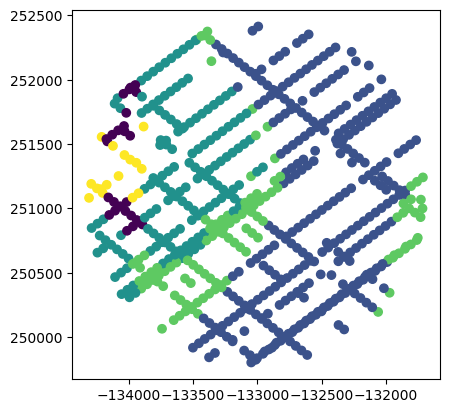

In [225]:
lala.plot(column='cluster')


<Axes: >

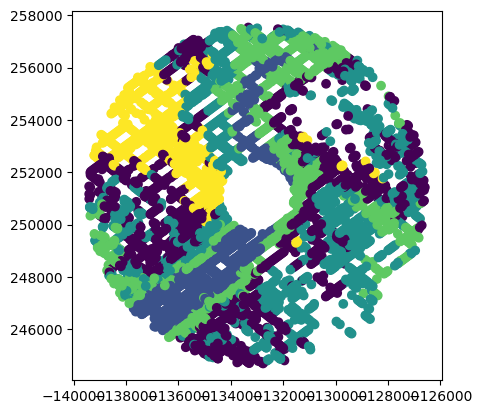

In [226]:
koko.plot(column='cluster')

Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
3
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
5
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
6
Enter clusteing knn
4
Enter clusteing knn
7
Enter clusteing knn
7
Enter clusteing knn
10
Enter clusteing knn
1

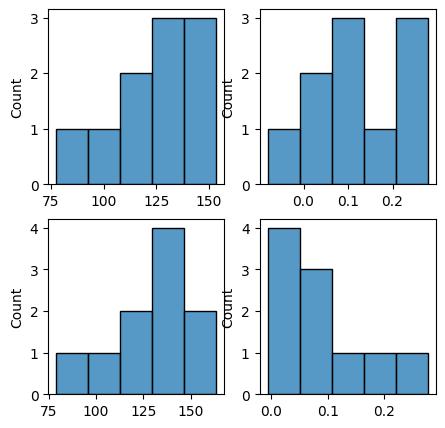

In [260]:
errors = None
columns_to_cluster = ["soil", "aspect", "elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
8
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
9
Enter clusteing knn
10
Enter clusteing knn
3
Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
10
Enter clusteing knn
9
Enter clusteing knn
4
Enter clusteing knn
7
Enter clusteing knn
4
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
10
Enter clusteing knn
7
Enter clusteing knn
8
Enter clusteing knn
8
Enter clusteing knn
6
Enter clusteing knn
7
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
7
Enter clusteing knn
4
Enter clusteing knn
4
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter clusteing knn
6
Enter

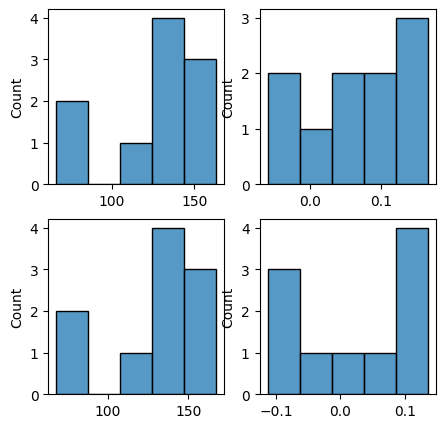

In [261]:
errors = None
columns_to_cluster = ["elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

In [267]:
errors = None
columns_to_cluster = ["elevation", "slope"]
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 3000, 100, 
    lambda x, y, z, t: terrain_clustering.match_with_nearest_shot_from_terrain_cluster(x, y, z, t, 10, columns_to_cluster))
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Enter clusteing knn
9
Enter clusteing knn
9
Enter clusteing knn
5
Enter clusteing knn
5
Enter clusteing knn
9
Enter clusteing knn
6
Enter clusteing knn
4
Enter clusteing knn
9
Enter clusteing knn
8
Enter clusteing knn
9
Enter clusteing knn


## Evaluate Algo 3 - nearest shots

In [175]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
114.24959233780596
0.10871262293453102
Median Errors:
115.87559689033904
0.0861257890039008


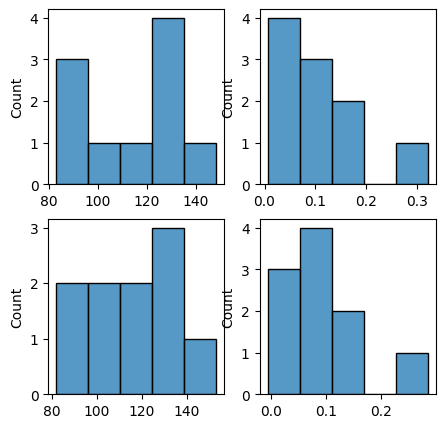

In [183]:
plot_errors(errors)

Mean Errors:
127.35195965240663
0.22135647579748982
Median Errors:
130.1541485026374
0.1861530549486341


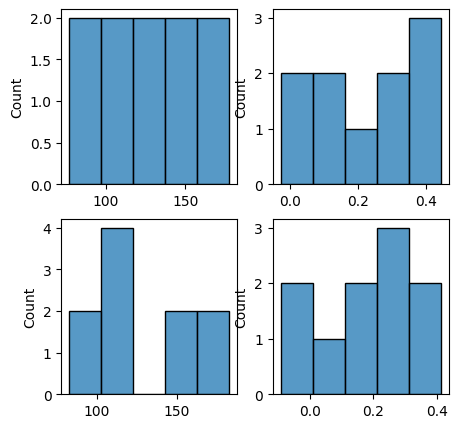

In [184]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 2000, 100, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

Mean Errors:
139.37776335844677
0.041196568814547474
Median Errors:
142.7791652999106
-0.002457568070915217


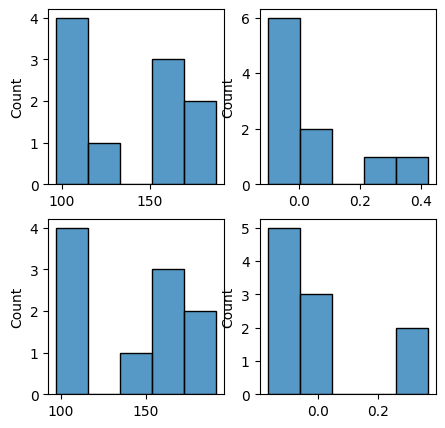

In [185]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 2000, 100, nearest.match_with_nearest_shot_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)
plot_errors(errors)

## Evaluate Algo 2 - match_with_random_shots_per_pixel

In [169]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, random_control.match_with_random_shots_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
108.13336450459258
0.08582488591688582
Median Errors:
111.49580281073777
0.04049863218766646


In [172]:
errors = None
for i in range(10):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 3000, 100, random_control.match_with_random_shots_per_pixel)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
118.37609054595907
0.09644992798876453
Median Errors:
120.92145345913511
0.05586549547988205


## Evaluate Algo 1 - match_with_random_shots_per_fire

In [171]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 5000, 200, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

print_errors(errors)

Mean Errors:
127.80795342941323
0.10685156862101217
Median Errors:
130.84504852145562
0.06647058343118677


In [146]:
print("Mean Errors:")
print(errors_5000_200[:, 0].mean())
print(errors_5000_200[:, 1].mean())

print("Median Errors:")
print(errors_5000_200[:, 2].mean())
print(errors_5000_200[:, 3].mean())

Mean Errors:
120.48717343848337
0.08640574756033949
Median Errors:
123.04210986632371
0.049506441436497683


In [148]:
errors = None
for i in range(50):
    new_errors = random_control.evaluate_random_control(5, gedi_unburned_3310, 3000, 200)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_3000_200 = errors

In [149]:
print("Mean Errors:")
print(errors_3000_200[:, 0].mean())
print(errors_3000_200[:, 1].mean())

print("Median Errors:")
print(errors_3000_200[:, 2].mean())
print(errors_3000_200[:, 3].mean())

Mean Errors:
120.98856668682728
0.13250114508119867
Median Errors:
123.71911115645881
0.0944546697105086


In [150]:
errors = None
for i in range(50):
    new_errors = random_control.evaluate_random_control(5, gedi_unburned_3310, 1000, 200)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_1000_200 = errors

In [151]:
print("Mean Errors:")
print(errors_1000_200[:, 0].mean())
print(errors_1000_200[:, 1].mean())

print("Median Errors:")
print(errors_1000_200[:, 2].mean())
print(errors_1000_200[:, 3].mean())

Mean Errors:
117.65896341359195
0.13351301923319503
Median Errors:
120.73940050181378
0.09038123497257378


In [155]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 1000, 500, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_1000_500 = errors

In [157]:
print("Mean Errors:")
print(errors_1000_500[:, 0].mean())
print(errors_1000_500[:, 1].mean())

print("Median Errors:")
print(errors_1000_500[:, 2].mean())
print(errors_1000_500[:, 3].mean())

Mean Errors:
118.12643763782195
0.15264078390390792
Median Errors:
120.52283470711403
0.12318618204494199


In [161]:
errors = None
for i in range(50):
    new_errors = eval.evaluate_control(5, gedi_unburned_3310, 1000, 5000, random_control.match_with_random_shots_per_fire)
    if errors is None:
        errors = new_errors
    else:
        errors = np.vstack((errors, new_errors))

errors_1000_5000 = errors

In [163]:
print("Mean Errors:")
print(errors_1000_5000[:, 0].mean())
print(errors_1000_5000[:, 1].mean())

print("Median Errors:")
print(errors_1000_5000[:, 2].mean())
print(errors_1000_5000[:, 3].mean())

Mean Errors:
121.64401967370915
0.11415161942434562
Median Errors:
123.59513797533573
0.08574878900678319


<Axes: ylabel='Count'>

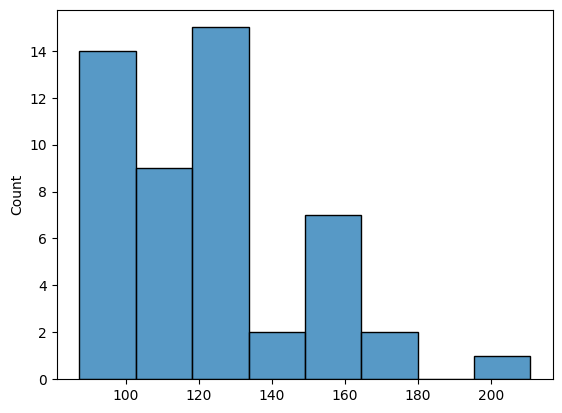

In [142]:
sns.histplot(errors_5000_200[:, 2])